# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) and pandas. 
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 204945323, 204502926 ***

In [ ]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from collections import defaultdict

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)  # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):
    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [ ]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

---
## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

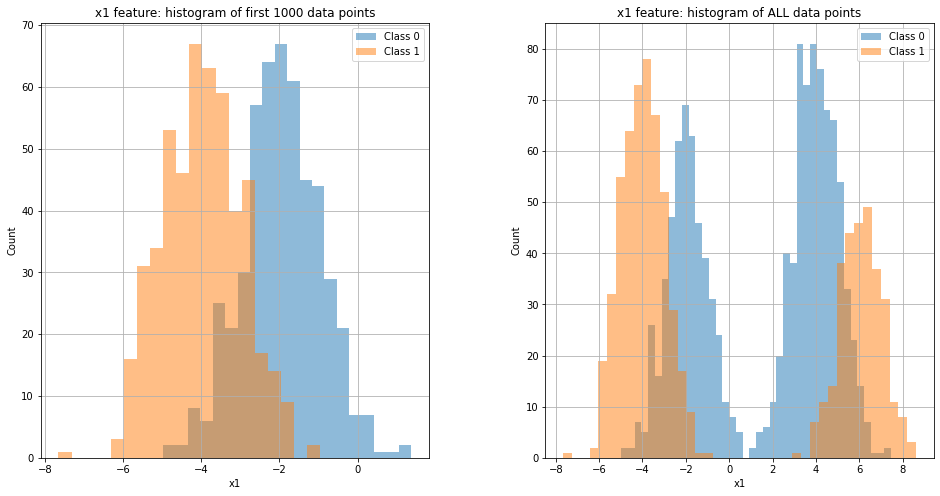

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

training_set[['x1', 'y']][:1000].groupby('y').hist(ax=ax[0], bins=20, alpha=0.5)
training_set[['x1', 'y']].groupby('y').hist(ax=ax[1], bins=40, alpha=0.5)

ax[0].set_title('x1 feature: histogram of first 1000 data points')
ax[1].set_title('x1 feature: histogram of ALL data points')

X_LABEL = 'x1'
Y_LABEL = 'Count'
LEGEND_TEXT = ['Class 0', 'Class 1']

for ax_i in ax:
    ax_i.set_xlabel(X_LABEL)
    ax_i.set_ylabel(Y_LABEL)
    ax_i.legend(LEGEND_TEXT)

plt.show()

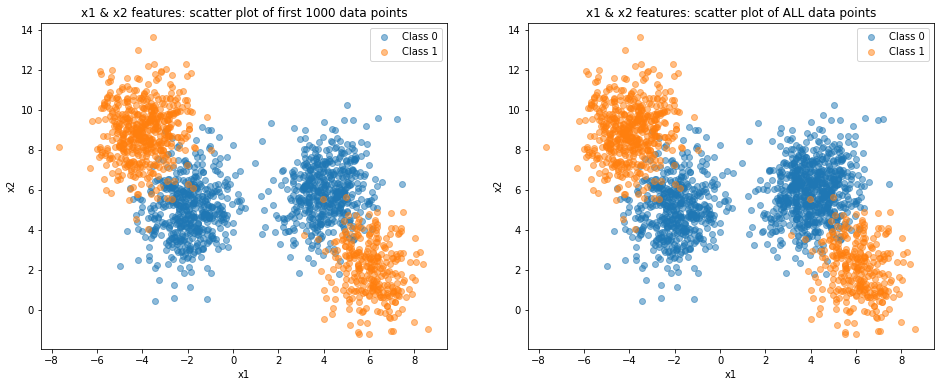

In [ ]:
class0 = training_set[training_set['y'] == 0]
class1 = training_set[training_set['y'] == 1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].scatter(data=training_set[training_set['y'] == 0][:1000], x='x1', y='x2', alpha=0.5, label='Class 0')
ax[0].scatter(data=training_set[training_set['y'] == 1][:1000], x='x1', y='x2', alpha=0.5, label='Class 1')

ax[1].scatter(data=training_set[training_set['y'] == 0], x='x1', y='x2', alpha=0.5, label='Class 0')
ax[1].scatter(data=training_set[training_set['y'] == 1], x='x1', y='x2', alpha=0.5, label='Class 1')

ax[0].set_title('x1 & x2 features: scatter plot of first 1000 data points')
ax[1].set_title('x1 & x2 features: scatter plot of ALL data points')

for ax_i in ax:
    ax_i.set_xlabel('x1')
    ax_i.set_ylabel('x2')
    ax_i.legend()

plt.show()

In [ ]:
def add_bias(data):
    """
    Input:
    - data: inputs  (n features over m instances).

    Returns data with a bias (column of 1's) as the first column.

    Example:
    X = [1, 2, 3] --> [1, 1]
                      [1, 2]
                      [1, 3]

    Note: np.c_
    """
    return np.c_[np.ones(len(data)), data]

---
## Logistic Regression

(15 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [ ]:
training_set.head()

,x1,x2,y
0,-1.385789,9.131464,0
1,-2.236903,5.561178,0
2,-2.362524,5.215973,0
3,-0.499655,4.981781,0
4,-2.976062,6.236138,0


In [ ]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight initialization.
    """
    
    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state
        
        # added fields:
        self.theta = None  # calculated in the learning phase
        self.J_history = []
        self.m = None

    def fit(self, X, y):
        """
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """
        self.m = len(y)  # m instances
        np.random.seed(self.random_state)
        X = add_bias(X)
        self.theta = np.random.random(X.shape[1])

        self.theta, self.J_history = self.gradient_descent(X, y, self.theta, self.eta, self.n_iter, self.eps)
        return

    def predict(self, x):
        """Return the predicted class label"""
        x_with_bias = add_bias(x)
        return np.round(self.sigmoid(x_with_bias @ self.theta))

    def sigmoid(self, v):
        exponent = np.exp(v)
        return exponent / (1 + exponent)

    def gradient_descent(self, X, y, thetas, alpha, num_iters, tolerance):
        # Efficient Gradient Descent
        theta = thetas.copy()  # avoid changing the original thetas
        J_history = []  # Use a python list to save cost in every iteration
        delta_J = float('inf')

        for i in range(num_iters):
            h = self.sigmoid(X @ theta)
            # SIMULTANEOUS UPDATE for all thetas:
            theta = theta - (alpha / self.m) * X.T @ (h - y)
            J_i = self.compute_cost(X, y, theta)
            J_history.append(J_i)

            if len(J_history) > 1:
                delta_J = abs(J_history[i] - J_history[i - 1])

            if delta_J <= tolerance:
                break

        return theta, J_history

    def compute_cost(self, X, y, theta):
        # simplified calculation from recitation didn't work - DELETE
        # mat_mul = X @ theta
        # ln_term = np.log(1 + np.exp(mat_mul))
        # J = -np.mean((y @ mat_mul) - ln_term)

        h = self.sigmoid(X @ theta)
        J = (1 / self.m) * (((-y) @ np.log(h)) - ((1 - y) @ np.log(1-h)))
        return J

In [ ]:
# model = LogisticRegressionGD()
# model.fit(X_training, y_training)
# test_pred = model.predict([X_training[0]])[0]
# test_pred

---
## Cross Validation

(5 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [ ]:
def cross_validate(training_set, k=5):
    shuffled_training_set = training_set.sample(frac=1)
    shuffled_X_training, shuffled_y_training = shuffled_training_set[['x1', 'x2']].values, shuffled_training_set['y'].values

    etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
    epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]

    m = X_training.shape[0]
    best_accuracy = float('-inf')
    temp_best_eps, temp_best_eta = None, None
    count = 1
    total_loops = len(etas) * len(epss)
    step = m // k

    for eta in etas:
        for eps in epss:
            print(f'Loop {count} / {total_loops}')
            print(f'Testing pair: {eta, eps}')
            fold_accuracy = []

            for i in range(0, m, step):
                curr_X_training_set = np.concatenate((shuffled_X_training[0:i], shuffled_X_training[i + step:]))
                curr_y_training_set = np.concatenate((shuffled_y_training[0:i], shuffled_y_training[i + step:]))

                curr_X_val_set, curr_y_val_set = shuffled_X_training[i:i + step], shuffled_y_training[i:i + step]

                model = LogisticRegressionGD(eta=eta, eps=eps)
                model.fit(curr_X_training_set, curr_y_training_set)
                y_pred = model.predict(curr_X_val_set)

                accuracy = np.mean(y_pred == curr_y_val_set)
                fold_accuracy.append(accuracy)

            fold_accuracy_mean = np.mean(fold_accuracy)
            print(f'Average accuracy = {fold_accuracy_mean * 100}%')

            if fold_accuracy_mean > best_accuracy:
                print('Best accuracy ^')
                temp_best_eps, temp_best_eta = eps, eta
                best_accuracy = fold_accuracy_mean

            count += 1
            print('---')

    return temp_best_eta, temp_best_eps

In [ ]:
%%time
best_eta, best_eps = cross_validate(training_set, 5)
print(best_eta, best_eps)

---
## Normal distribution pdf

(2 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [ ]:
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    return np.exp( -(((data - mu) / sigma) ** 2) / 2) / (sigma * np.sqrt(2 * np.pi))

In [ ]:
def gmm_likelihood(data, params):
    w = [params[0].get('w'), params[1].get('w')]
    norms_per_k = [norm_pdf(data, params[k].get('mu'), params[k].get('sig')) for k in range(
        len(params))]
    likelihoods = np.multiply(np.stack(norms_per_k, axis=-1), w)
    return likelihoods

---
## Expectation Maximization

(15 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [ ]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = 10

        self.dist_params = dict()  # 1: (mu_1, sig_1, w1), per k

    def init_params(self, data):
        """
        Initialize distribution params
        """
        random.seed(self.random_state)
        params = dict()

        for i in range(self.k):
            params[i] = {'mu': np.random.random(), 'sig': np.random.random(), 'w': 1 / self.k}

        self.dist_params = params

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        # calculate likelihoods of all data for each GMM
        likelihoods = np.array(
            [norm_pdf(data, self.dist_params[k]['mu'], self.dist_params[k]['sig']) * self.dist_params[k]['w'] for k in
             range(self.k)])

        # divide by sum of likelihoods across instances to get responsibilities
        resps = likelihoods / np.sum(likelihoods, axis=0)

        return resps, likelihoods

    def maximization(self, data, resps):
        """
        M step - updating distribution params
        """

        new_weights = np.mean(resps, axis=1)

        new_mus = np.sum(np.array([np.multiply(resps[k], data) for k in range(self.k)]), axis=1) / (
                    new_weights * data.shape[0])

        new_sigmas = np.sqrt(np.mean(np.multiply(resps, np.power(np.array([data - new_mus[k] for k in range(
            self.k)]), 2)), axis=1))

        # update dist_params
        for k in range(self.k):
            self.dist_params[k]['w'] = new_weights[k]
            self.dist_params[k]['mu'] = new_mus[k]
            self.dist_params[k]['sig'] = new_sigmas[k]

        return

    def cost_function(self, likelihoods):
        """
        Calculate the cost of teh GMM given the current distribution parameters (the neg log likelihood)
        """
        return np.sum(-np.log2(np.sum(likelihoods, axis=1)))

    def fit(self, data):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        prev_cost = float('inf')

        for i in range(self.n_iter):
            # calculate responsibilites
            resps, likelihoods = self.expectation(data)

            # update the current distribution params
            self.maximization(data, resps)

            # calculate cost of params
            current_cost = self.cost_function(likelihoods)

            if abs(prev_cost - current_cost) < self.eps:
                return self.dist_params

            prev_cost = current_cost

        return self.dist_params

    def get_dist_params(self):
        return self.dist_params

---
## Naive Bayes

(15 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


# **NOTE TO GRADER **

We were sadly unable to get our own implementation of EM running correctly in time.
Our code is written above, but does not produce suffecient paramaters.

For the sake of completing the assignment (being able to use Naive Bayes and following parts), we used an external library to run the EM algorithm.

In [ ]:
from sklearn.mixture import GaussianMixture

In [ ]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gausian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1):
        self.k = k
        self.num_classes = 2
        self.priors = None
        self.models = {}

    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """

        num_feat = X.shape[1]

        # estimate likihoods using EM
        for c in range(self.num_classes):

            # calculate priors
            self.priors = np.array([(np.where(y == c)[0].shape[0] / y.shape[0]) for c in range(
                self.num_classes)])

            for f in range(num_feat):
                # estimate params of each GMM, and take product of likelihoods per class
                # self.models[(f, c)] = EM(self.k).fit(data=X[y == c, f])
                self.models[(f, c)] = GaussianMixture(n_components=self.k, random_state=0).\
                    fit(np.array([[row] for row in X[y == c, f]]))

    def predict(self, X):
        """Return the predicted class label"""

        self.posteriors = []
        for c in range(self.num_classes):
            output = np.ones(X.shape[0]) * self.priors[c]
            for f in range(X.shape[1]):
                model = self.models[(f, c)]
                likelihoods = gmm_likelihood(X[:, f], get_gmm_param_dict(model))
                output = np.multiply(output, np.max(likelihoods, axis=1))
            self.posteriors.append(output)
            
        max_posterior = np.argmax(np.stack(self.posteriors, axis=1), axis=1)

        return max_posterior

In [ ]:
def get_gmm_param_dict(model):
    return {0: {'mu': model.means_[0][0], 'sig': model.covariances_[0][0][0], 'w': model.weights_[0]},
            1: {'mu': model.means_[1][0], 'sig': model.covariances_[1][0][0], 'w': model.weights_[1]}}

---
## Model evaluation

(20 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points
1. Provide one or two sentences on each graph explaining what you observe in the graph.

#### Don't forget to label your graphs ####

## Answer:

#**Using the first 1000 training points and first 500 test points:**

In [ ]:
# #### Your code here ####

X_training_subset, y_training_subset = X_training[:1000], y_training[:1000]
X_test_subset, y_test_subset = X_test[:500], y_test[:500]

N_training = len(y_training_subset)  # 1000
N_test = len(y_test_subset)  # 500

### Logistic Regression ###
lr_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_model.fit(X_training_subset, y_training_subset) # on training set ONLY

lr_training_predictions = lr_model.predict(X_training_subset)
lr_test_predictions = lr_model.predict(X_test_subset)

lr_training_accuracy = (y_training_subset == lr_training_predictions).sum() / N_training
lr_test_accuracy = (y_test_subset == lr_test_predictions).sum() / N_test

print('Logistic Regression accuracies')
print('-'*15)
print(f'training: {lr_training_accuracy * 100}%')
print(f'test: {lr_test_accuracy * 100}%')


## Naive Bayes ###
nb_model = NaiveBayesGaussian(k=2)
nb_model.fit(X_training, y_training)

nb_training_predictions = nb_model.predict(X_training_subset)
nb_test_predictions = nb_model.predict(X_test_subset)

nb_training_accuracy = (y_training_subset == nb_training_predictions).sum() / N_training
nb_test_accuracy = (y_test_subset == nb_test_predictions).sum() / N_test

print('Naive Bayes accuracies')
print('-'*15)
print(f'training: {nb_training_accuracy * 100}%')
print(f'test: {nb_test_accuracy * 100}%')

Naive Bayes accuracies
---------------
training: 92.60000000000001%
test: 90.60000000000001%


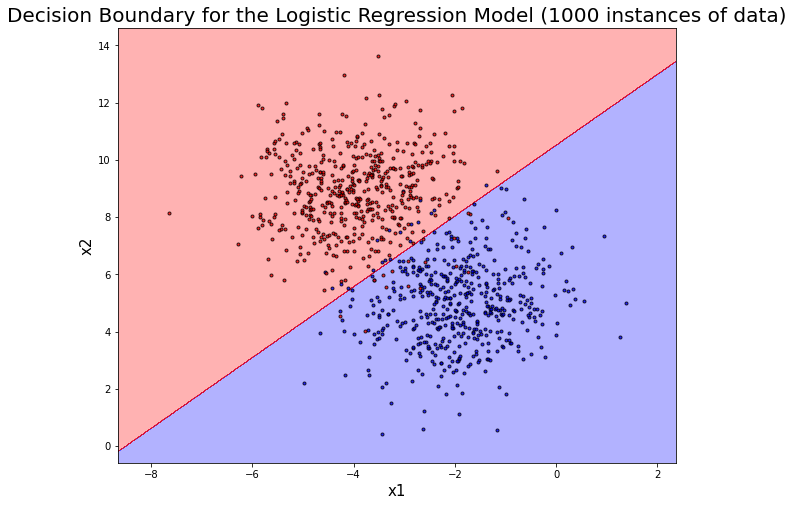

In [ ]:
plot_decision_regions(X_training_subset, y_training_subset, lr_model)
plt.title('Decision Boundary for the Logistic Regression Model (1000 instances of data)', fontsize=20)
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.show()

In [ ]:
# plot_decision_regions(X_training_subset, y_training_subset, nb_model)
# plt.title('Decision Boundary for the Naive Bayes Model (1000 instances of data)', fontsize=20)
# plt.xlabel('x1', fontsize=15)
# plt.ylabel('x2', fontsize=15)
# plt.show()

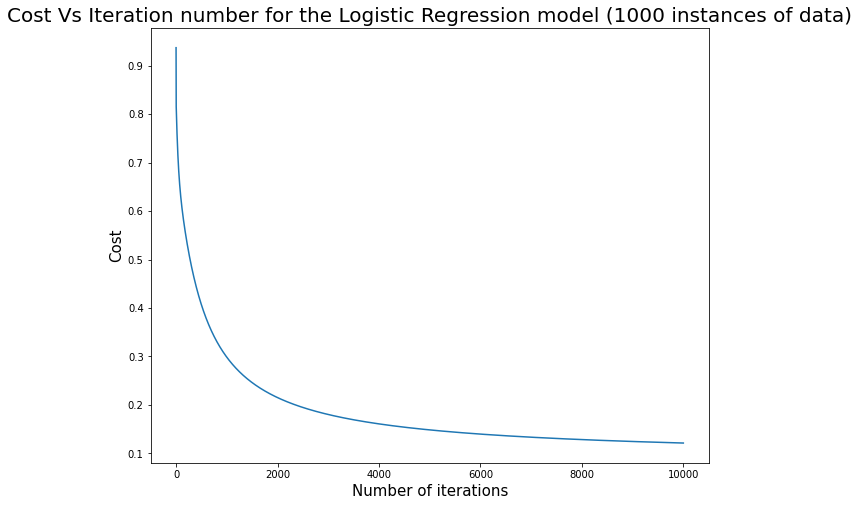

In [ ]:
# NEED TO FIX VALUES SOMEHOW!!!
plt.plot(lr_model.J_history)
plt.title('Cost Vs Iteration number for the Logistic Regression model (1000 instances of data)', fontsize=20)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.show()

#**Using ALL training points and all test points:**

In [ ]:
N_training = len(y_training)
N_test = len(y_test)

### Logistic Regression ###
lr_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_model.fit(X_training, y_training) # on training set ONLY

lr_training_predictions = lr_model.predict(X_training)
lr_test_predictions = lr_model.predict(X_test)

lr_training_accuracy = (y_training == lr_training_predictions).sum() / N_training
lr_test_accuracy = (y_test == lr_test_predictions).sum() / N_test

print('Logistic Regression accuracies')
print('-'*15)
print(f'training: {lr_training_accuracy * 100}%')
print(f'test: {lr_test_accuracy * 100}%')


### Naive Bayes ###
# nb_model = NaiveBayesGaussian(k=2)
# nb_model.fit(training_data, y_training)

# nb_training_predictions = nb_model.predict(X_training)
# nb_test_predictions = nb_model.predict(X_test)

# nb_training_accuracy = (y_training == nb_training_predictions).sum() / N_training
# nb_test_accuracy = (y_test == nb_test_predictions).sum() / N_test

# print('Naive Bayes accuracies')
# print('-'*15)
# print(f'training: {nb_training_accuracy * 100}%')
# print(f'test: {nb_test_accuracy * 100}%')

Logistic Regression accuracies
---------------
training: 79.60000000000001%
test: 79.2%


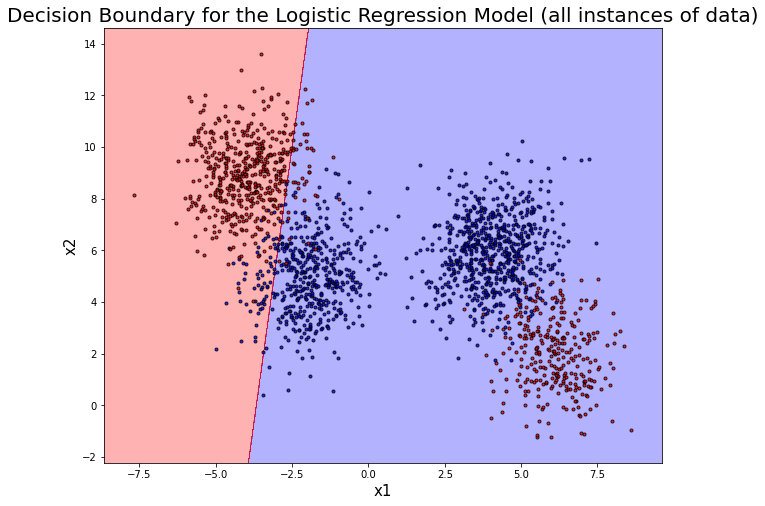

In [ ]:
plot_decision_regions(X_training, y_training, lr_model)
plt.title('Decision Boundary for the Logistic Regression Model (all instances of data)', fontsize=20)
plt.xlabel('x1', fontsize=15)
plt.ylabel('x2', fontsize=15)
plt.show()

In [ ]:
# plot_decision_regions(X_training, y_training, nb_model)
# plt.title('Decision Boundary for the Naive Bayes Model (all instances of data)', fontsize=20)
# plt.xlabel('x1', fontsize=15)
# plt.ylabel('x2', fontsize=15)
# plt.show()

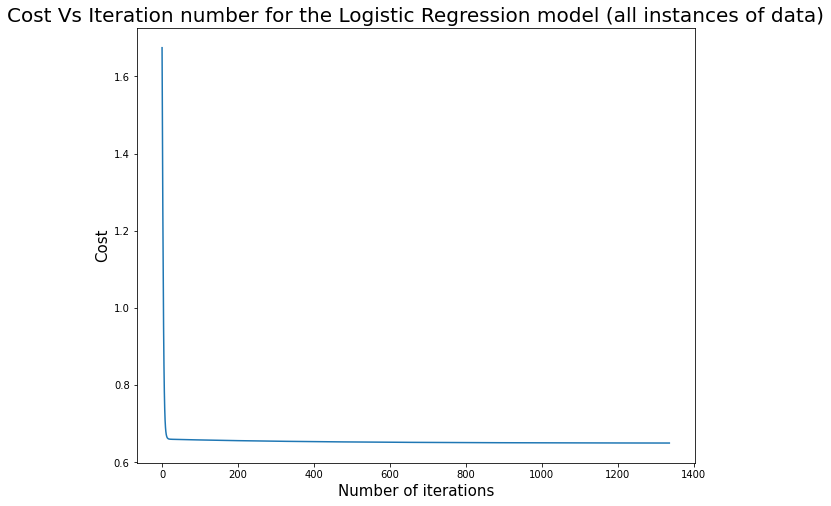

In [ ]:
plt.plot(lr_model.J_history)
plt.title('Cost Vs Iteration number for the Logistic Regression model (all instances of data)', fontsize=20)
plt.xlabel('Number of iterations', fontsize=15)
plt.ylabel('Cost', fontsize=15)
plt.show()

<!-- Provide one or two sentences on each graph explaining what you observe in the graph. -->

On the first "cost vs iteration" graph we can see that the weights we're learning converge to better values (fitting the training set well)

On the second graph, we 

---
## Open question

(20 points) 

1. In this homework we explored two types of models: Naive Bayes using EM, and Logistic regression.  
    - Generate one dataset that you think Naive Bayes will work better than Logisitc Regression.
    - Generate another dataset that you think Logistic Regression will work better than Naive Bayes using EM.
    - Explain the reasoning behind each dataset.  

(The number of features and instances is up to you, but use only 2 classes)

2. Visualize the datasets like in the beginning of this notebook.

#### Your code and explanations here ####


In [ ]:
# custom-made data for the purpose of the question

data_where_naive_is_better = {'x1': [1, 2, 3], 'x2': [2, 2, 2], 'y': [0, 1, 0]}
data_where_naive_is_better = pd.DataFrame(data_where_naive_is_better)

x1_class_0 = np.arange(10).tolist()
x1_class_1 = x1_class_0

x2_class_0 = [x + 1 for x in x1_class_0]
x2_class_1 = [x - 1 for x in x2_class_0]

data_where_lr_is_better = {'x1': x1_class_0 + x1_class_1, 'x2': x2_class_0 + x2_class_1, 'y': [0] * len(x1_class_0) + [1] * len(x2_class_0)}  
data_where_lr_is_better = pd.DataFrame(data_where_lr_is_better)

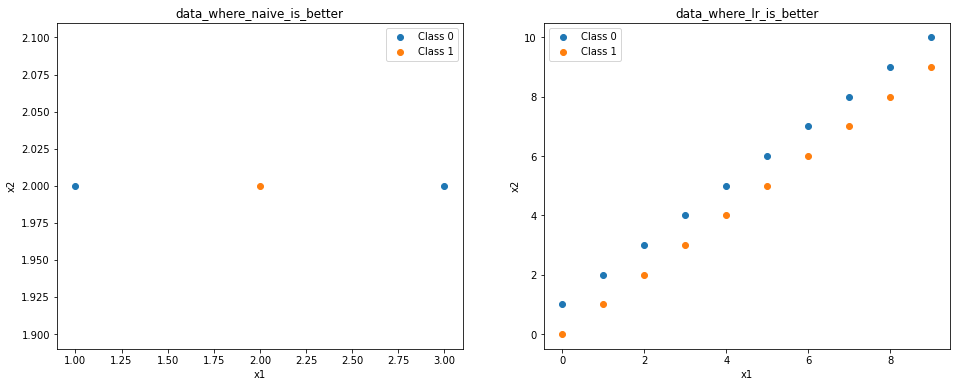

In [ ]:
class0 = data_where_naive_is_better[data_where_naive_is_better['y'] == 0]
class1 = data_where_naive_is_better[data_where_naive_is_better['y'] == 1]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

ax[0].scatter(data=data_where_naive_is_better[data_where_naive_is_better['y'] == 0], x='x1', y='x2', label='Class 0')
ax[0].scatter(data=data_where_naive_is_better[data_where_naive_is_better['y'] == 1], x='x1', y='x2', label='Class 1')

ax[1].scatter(data=data_where_lr_is_better[data_where_lr_is_better['y'] == 0], x='x1', y='x2', label='Class 0')
ax[1].scatter(data=data_where_lr_is_better[data_where_lr_is_better['y'] == 1], x='x1', y='x2', label='Class 1')

ax[0].set_title('data_where_naive_is_better')
ax[1].set_title('data_where_lr_is_better')

for ax_i in ax:
    ax_i.set_xlabel('x1')
    ax_i.set_ylabel('x2')
    ax_i.legend()

plt.show()

Since we weren't able to fully implement the EM class, we explain our data verbally:

On the left plot, the data is NOT linearly-separable.<br>
Thus, the Logistic Regression algorithm will perform poorly and will pass a separator between the red point and one of the 2 blue points - resulting in an accuracy of 66%, with one red point missclassified.<br>
Naive Bayes, on the other hand, will classify this data perfectly since it doesn't look for linear-separability and the data IS separable.<br>
The result will be of the form:<br>
blue **)** red **(**  blue



On the right plot, the data IS linearly-separable.<br>
Thus, the Logistic Regression algorithm will perform perfectly and will pass a separator between the red points and the blue points.<br>
Naive Bayes, on the other hand, will classify this data poorly since it assumes independence between features x1 & x2 which are clearly highly-dependent.<br>
In real life, it is almost impossible that we get a set of features which are completely independent.<br>
The result will be similar to an example that was given in class: Just a random mix between all points (where some are blue and are red).

For example (the shape will be of the actual data):

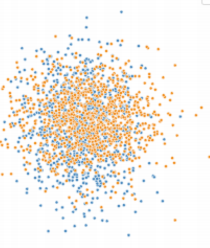

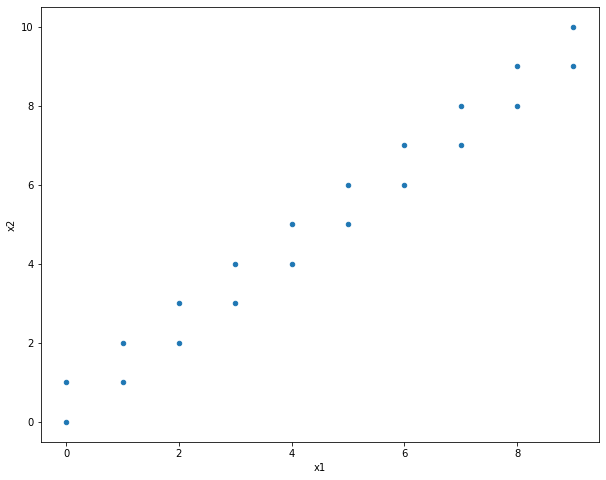

In [ ]:
df = pd.DataFrame(data_where_lr_is_better, columns=['x1','x2', 'y'])
df.plot(x ='x1', y='x2', kind = 'scatter')
plt.show()